In [1]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

RESULTS_PATH = "resultsGA"

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [2]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree

# def readGraph(filePath):
#     graph = nx.Graph()
#     with open(filePath) as f:
#         lines = f.readlines()

#         #.txt fajl, da ne pukne osiguravamo se zbog pocetka sa p
#         pLine = [l for l in lines if l.startswith('p')]
#         if pLine:
#             numNodes = int(pLine[0].split()[2])
#         else:
#             numNodes = int(lines[0].split()[2])
        

#         #numNodes = int(lines[0].split()[2])
#         # Normalizacija grana: sorted osigurava da je (1,2) isto što i (2,1)
#         rawEdges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
#         edges = [tuple(sorted(edge)) for edge in rawEdges]
#         graph.add_nodes_from(range(1, numNodes + 1))
#         graph.add_edges_from(edges)
#     return graph
def readGraph(filePath):
    graph = nx.Graph()
    with open(filePath, 'r') as f:
        lines = f.readlines()
    
    edges = []
    numNodes = 0
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        parts = line.split()
        
        # 1. Ako linija ima 'edge', to je zaglavlje (npr. p edge 11 55)
        if 'edge' in parts:
            try:
                # Obično je broj čvorova na indeksu 2
                numNodes = int(parts[2])
            except (IndexError, ValueError):
                pass
            continue

        # 2. Ako linija počinje sa 'p' ili 'e' i ima bar 3 dela (npr. p 1 2 ili e 1 2)
        if (parts[0] == 'p' or parts[0] == 'e') and len(parts) >= 3:
            try:
                # Pokušavamo da kastujemo drugi i treći deo u brojeve
                u, v = int(parts[1]), int(parts[2])
                edges.append((u, v))
            except ValueError:
                # Ako nisu brojevi, ignorišemo (to je verovatno neki tekst)
                continue
        
        # 3. Ako su samo dva broja u redu bez slova (neki fajlovi su i takvi)
        elif len(parts) == 2:
            try:
                u, v = int(parts[0]), int(parts[1])
                edges.append((u, v))
            except ValueError:
                continue

    if edges:
        graph.add_edges_from(edges)
        # Ako nismo izvukli numNodes iz zaglavlja, uzmi najveći nađeni broj čvora
        if numNodes == 0:
            numNodes = max(max(u, v) for u, v in edges)
        
        # Dodajemo sve čvorove (da osiguramo izolovan čvor ako postoji)
        graph.add_nodes_from(range(1, numNodes + 1))
        
    return graph

def getFitness(chromosome, edges, maxNode):
    conflicts = 0
    nodeMap = {i: [] for i in range(1, maxNode + 1)}
    for i, color in enumerate(chromosome):
        u, v = edges[i]
        nodeMap[u].append(color)
        nodeMap[v].append(color)
    for node in nodeMap:
        colors = nodeMap[node]
        if len(colors) > 1:
            conflicts += (len(colors) - len(set(colors)))
    return conflicts

In [3]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)[::-1] 
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = rank + 1
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]

In [4]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]

In [5]:
def mutationSmart(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
    available = list(set(range(1, delta + 2)) - forbidden)
    if available:
        chromosome[idx] = random.choice(available)
    else:
        chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationRandom(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationSwap(chromosome, edges, maxNode, delta):
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

In [6]:
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc):
    edges = list(graph.edges())
    if not edges: return [], 0, []
    maxNode, delta, numEdges = max(graph.nodes()), maxNumOfColours(graph), len(edges)
    population = [[random.randint(1, delta + 1) for _ in range(numEdges)] for _ in range(popSize)]
    
    history = [] # Za grafikon konvergencije
    
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        bestFit = min(fitnesses)
        history.append(bestFit)
        
        if bestFit == 0:
            history.extend([0] * (maxIters - len(history)))
            break
            
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]] # Elitizam
        
        while len(newPop) < popSize:
            p1, p2 = selFunc(population, fitnesses), selFunc(population, fitnesses)
            child = crossFunc(p1, p2)
            if random.random() < 0.3:
                child = mutFunc(child, edges, maxNode, delta)
            newPop.append(child)
        population = newPop
        
    finalFits = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFits)
    return population[bestIdx], finalFits[bestIdx], history

In [7]:
# def processAndVisualize(filePath):
#     graph = readGraph(filePath)
#     fileName = os.path.basename(filePath)
#     delta = maxNumOfColours(graph)
    
#     selections = [selectionTournament, selectionRoulette, selectionRank]
#     crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
#     mutations = [mutationRandom, mutationSmart, mutationSwap]
    
#     allResults = []

#     print(f"\n>>> ANALYZING GRAPH: {fileName}")
#     for sel in selections:
#         for cross in crossovers:
#             for mut in mutations:
#                 sName = sel.__name__.replace('selection', '')
#                 cName = cross.__name__.replace('crossover', '')
#                 mName = mut.__name__.replace('mutation', '')
                
#                 t0 = time.perf_counter()
#                 sol, fit, hist = runGaModular(graph, 250, 40, sel, cross, mut)
#                 dt = time.perf_counter() - t0
                
#                 allResults.append({
#                     'selection': sName,
#                     'crossover': cName,
#                     'mutation': mName,
#                     'fit': fit,
#                     'time': dt,
#                     'hist': hist,
#                     'sol': sol
#                 })

#     allResults.sort(key=lambda x: (x['fit'], x['time']))
    
#     # odvojene kolone
#     fullTableData = []
#     for i, r in enumerate(allResults):
#         fullTableData.append([
#             i, 
#             r['selection'], 
#             r['crossover'], 
#             r['mutation'], 
#             r['fit'], 
#             delta + 1, 
#             f"{r['time']:.6f}"
#         ])

#     headers = ["", "selection", "crossover", "mutation", "num of conf", "colours", "time"]

#     # 1. konzola: top 3
#     print(f"Top 3 Combinations for {fileName}:")
#     print(tabulate(fullTableData[:3], headers=headers, tablefmt="fancy_grid"))

#     # 2. fajl: svih 27
#     txtPath = os.path.join(RESULTS_PATH, fileName) 
#     with open(txtPath, 'w', encoding='utf-8') as f:
#         f.write(f"Graph can be coloured with {delta} or {delta+1} colours. Class 1 or class 2 respectively.\n")
#         f.write(tabulate(fullTableData, headers=headers, tablefmt="fancy_grid"))
#         if allResults[0]['fit'] == 0:
#             f.write(f"\nGraph is class 1, meaning chromatic index is equal to the graph's degree.")
#         else:
#             f.write(f"\nNo conflict-free colouring is found, therefore graph is classified as class 2.")

#     # 3. VIZUELIZACIJA
#     plt.figure(figsize=(16, 7))
    
#     # podplot 1: Obojeni graf
#     plt.subplot(1, 2, 1)
#     pos = nx.spring_layout(graph, seed=42)
#     nx.draw(graph, pos, edge_color=allResults[0]['sol'], width=2, with_labels=True, 
#             node_color='lightblue', edge_cmap=plt.cm.rainbow)
#     plt.title(f"Winner (Rank 0):\n{allResults[0]['selection']} + {allResults[0]['crossover']} + {allResults[0]['mutation']}")

#     # podplot 2: Konvergencija
#     plt.subplot(1, 2, 2)
#     for i in range(min(3, len(allResults))):
#         res = allResults[i]
#         # ISPIS SVA TRI OPERATORA U LEGENDI:
#         label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
#         plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
#     # osa
#     plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
#     plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
#     plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    
#     # namestanje legende
#     plt.legend(loc='upper right', fontsize='small')
#     plt.grid(True, linestyle=':', alpha=0.8)
    
#     plt.tight_layout()
#     plt.show()

#     plt.close('all')#dodato naknadno

#     print(f"Full table (27 combinations) saved to: {txtPath}")
def processAndVisualize(filePath):
    graph = readGraph(filePath)
    fileName = os.path.basename(filePath)
    delta = maxNumOfColours(graph)
    
    # Provera da li je graf prazan
    if graph.number_of_edges() == 0:
        print(f"Preskačem {fileName} - graf nema ivica.")
        return

    # --- TEORIJSKA ANALIZA ---
    f_lower = fileName.lower()
    type_info = "Unknown Graph Type"
    theory_note = ""

    # 1. Provera bipartitnosti (Strukturna)
    is_bipartite = nx.is_bipartite(graph)

    # 2. Identifikacija na osnovu imena fajla
    if "completegraph" in f_lower or "k_" in f_lower:
        try:
            # Izvlači broj iz imena (npr. completeGraph11 -> 11)
            n = int(''.join(filter(str.isdigit, fileName)))
            type_info = f"Complete Graph K({n})"
            if n % 2 == 0:
                theory_note = f"Class 1 (Expected χ' = Δ = {n-1})"
            else:
                theory_note = f"Class 2 (Expected χ' = Δ + 1 = {n})"
        except:
            type_info = "Complete Graph"

    elif "bipartite" in f_lower or is_bipartite:
        type_info = "Bipartite Graph"
        theory_note = f"Always Class 1 (Expected χ' = Δ = {delta})"
        if not "bipartite" in f_lower:
            type_info += " (Detected structurally!)"

    elif "petersen" in f_lower or "snark" in f_lower or "flower" in f_lower:
        type_info = "SNARK / Petersen Graph"
        theory_note = f"Class 2 (Expected χ' = Δ + 1 = {delta+1})"

    elif "regular" in f_lower:
        type_info = f"Random Regular Graph (d={delta})"
        theory_note = "Most are Class 1"

    elif "graph" in f_lower:
        type_info = "Random G(n,p) Graph"
        theory_note = "Vizing's Theorem: Class 1 or 2"

    print(f"\n>>> ANALYZING: {fileName}")
    print(f"[TYPE]: {type_info}")
    if theory_note:
        print(f"[THEORY]: {theory_note}")

    # --- GA POKRETANJE ---
    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
    mutations = [mutationRandom, mutationSmart, mutationSwap]
    
    allResults = []

    for sel in selections:
        for cross in crossovers:
            for mut in mutations:
                sName = sel.__name__.replace('selection', '')
                cName = cross.__name__.replace('crossover', '')
                mName = mut.__name__.replace('mutation', '')
                
                t0 = time.perf_counter()
                # Smanji 250 na 100 ako ti je preporo za velike grafove
                sol, fit, hist = runGaModular(graph, 250, 40, sel, cross, mut)
                dt = time.perf_counter() - t0
                
                allResults.append({
                    'selection': sName, 'crossover': cName, 'mutation': mName,
                    'fit': fit, 'time': dt, 'hist': hist, 'sol': sol
                })

    allResults.sort(key=lambda x: (x['fit'], x['time']))
    
    fullTableData = []
    for i, r in enumerate(allResults):
        fullTableData.append([
            i, r['selection'], r['crossover'], r['mutation'], 
            r['fit'], delta + 1, f"{r['time']:.6f}"
        ])

    headers = ["Rank", "Selection", "Crossover", "Mutation", "Conflicts", "Colours", "Time"]

    # 1. Top 3
    print(f"Top 3 Combinations for {fileName}:")
    print(tabulate(fullTableData[:3], headers=headers, tablefmt="fancy_grid"))

    # 2. Fajl: upisivanje rezultata
    txtPath = os.path.join(RESULTS_PATH, fileName) 
    with open(txtPath, 'w', encoding='utf-8') as f:
        f.write(f"Graph: {fileName} | Type: {type_info}\n")
        f.write(f"Theory: {theory_note}\n")
        f.write(f"Max Degree (Delta): {delta}\n\n")
        f.write(tabulate(fullTableData, headers=headers, tablefmt="fancy_grid"))
        
        if allResults[0]['fit'] == 0:
            f.write(f"\n\nRESULT: Class 1 found (Chromatic Index = {delta})")
        else:
            f.write(f"\n\nRESULT: Class 2 or GA failed (Best conflicts: {allResults[0]['fit']})")

    # 3. VIZUELIZACIJA
    plt.figure(figsize=(16, 7))
    
    # Podplot 1: Obojeni graf
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(graph, seed=42)
    # Popravljeno bojenje ivica
    nx.draw(graph, pos, edge_color=allResults[0]['sol'], width=2.5, with_labels=True, 
            node_color='lightblue', edge_cmap=plt.cm.rainbow, node_size=500)
    plt.title(f"Winner (Rank 0):\n{allResults[0]['selection']}+{allResults[0]['crossover']}+{allResults[0]['mutation']}")

    # Podplot 2: Konvergencija
    plt.subplot(1, 2, 2)
    for i in range(min(3, len(allResults))):
        res = allResults[i]
        # Labela sa SVA TRI operatora u legendi
        label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
        plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    plt.xlabel("Generations")
    plt.ylabel("Number of Conflicts")
    plt.title(f"Convergence Race: {fileName}")
    plt.legend(loc='upper right', fontsize='x-small')
    plt.grid(True, linestyle=':', alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    plt.close('all')

    print(f"Full table saved to: {txtPath}")
    


########################################
# ENTERING FOLDER: experimentalTests
########################################

>>> ANALYZING: completeBipartite10.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 10)
Top 3 Combinations for completeBipartite10.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Rank        │ SinglePoint │ Smart      │           1 │        11 │ 0.763227 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Roulette    │ TwoPoint    │ Smart      │           2 │        11 │ 0.398994 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │           2 │        11 │ 0.400281 │
╘═══════

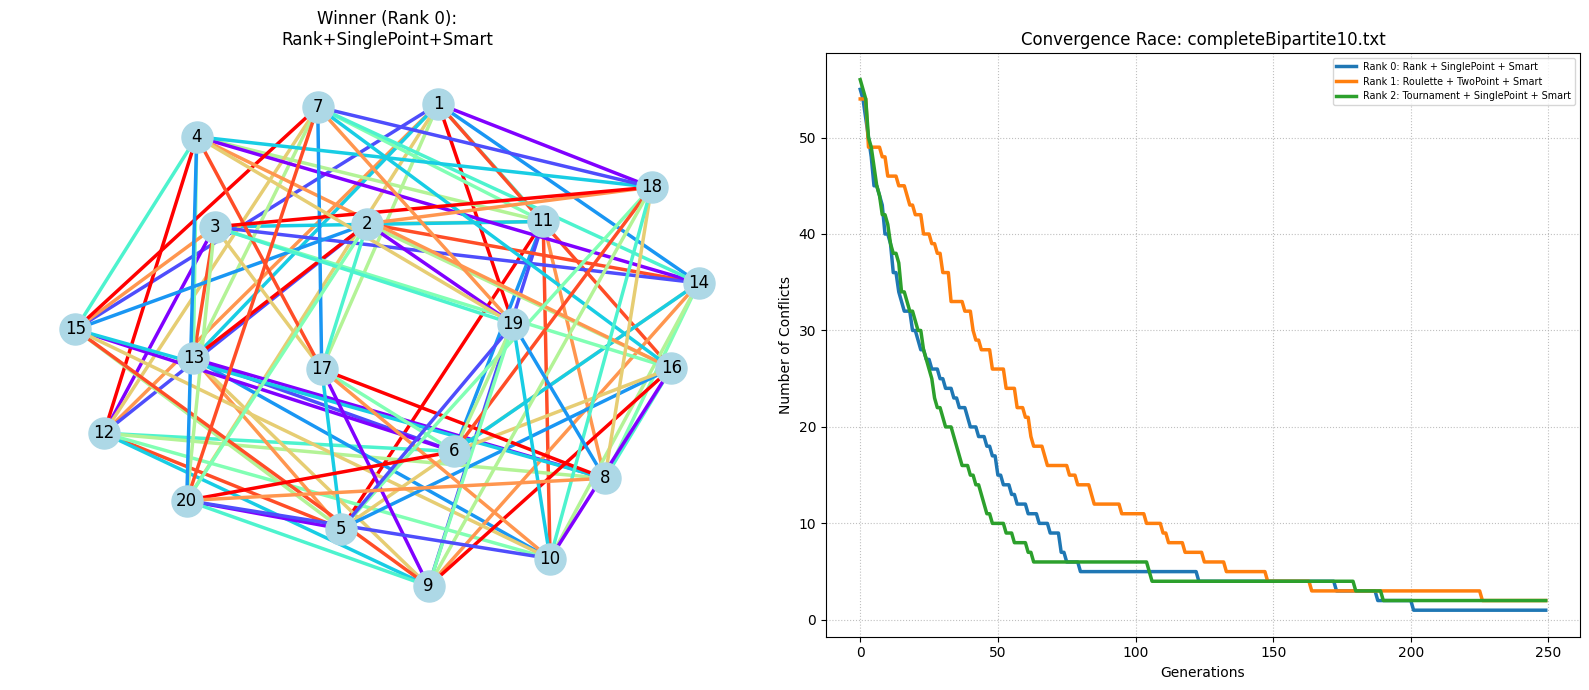

Full table saved to: resultsGA/completeBipartite10.txt

>>> ANALYZING: completeBipartite20.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 20)
Top 3 Combinations for completeBipartite20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤═════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │    Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │          30 │        21 │ 1.13157 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │          31 │        21 │ 1.52569 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │          34 │        21 │ 1.09756 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧════

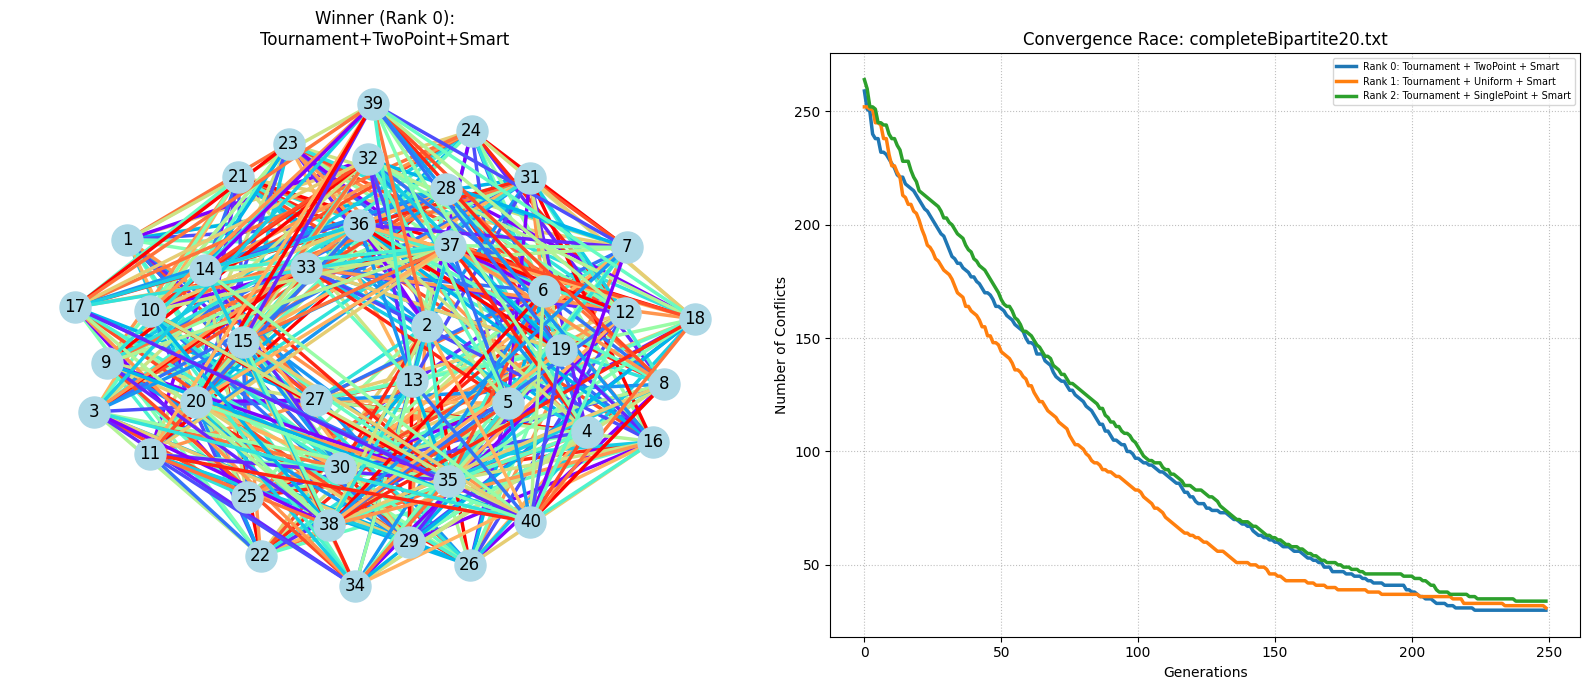

Full table saved to: resultsGA/completeBipartite20.txt

>>> ANALYZING: completeGraph11.txt
[TYPE]: Complete Graph K(11)
[THEORY]: Class 2 (Expected χ' = Δ + 1 = 11)
Top 3 Combinations for completeGraph11.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Roulette    │ TwoPoint    │ Random     │           1 │        11 │ 0.251468 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Roulette    │ SinglePoint │ Smart      │           1 │        11 │ 0.268864 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │           1 │        11 │ 0.268872 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══

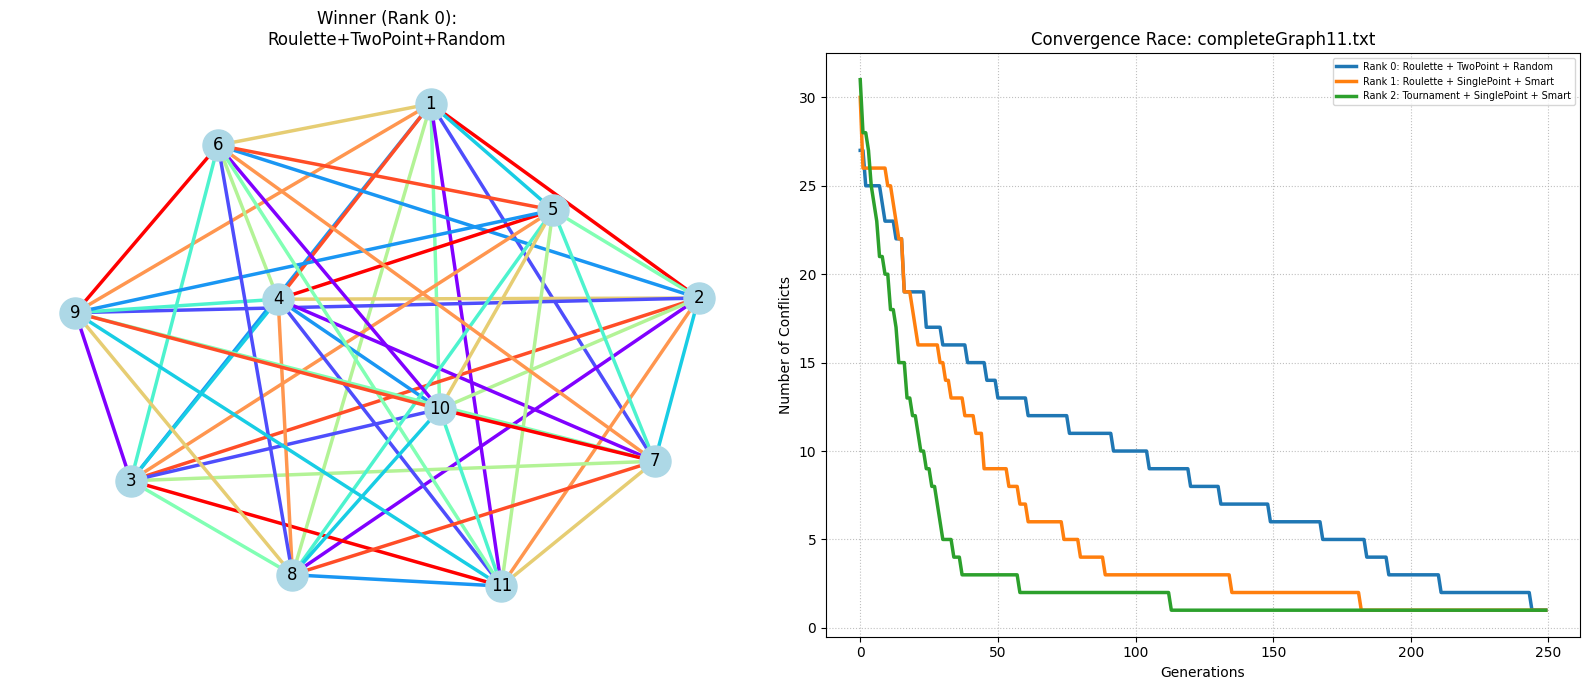

Full table saved to: resultsGA/completeGraph11.txt

>>> ANALYZING: completeGraph20.txt
[TYPE]: Complete Graph K(20)
[THEORY]: Class 1 (Expected χ' = Δ = 19)
Top 3 Combinations for completeGraph20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │           9 │        20 │ 0.590288 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │          10 │        20 │ 0.774195 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Rank        │ SinglePoint │ Smart      │          10 │        20 │ 0.9883   │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════

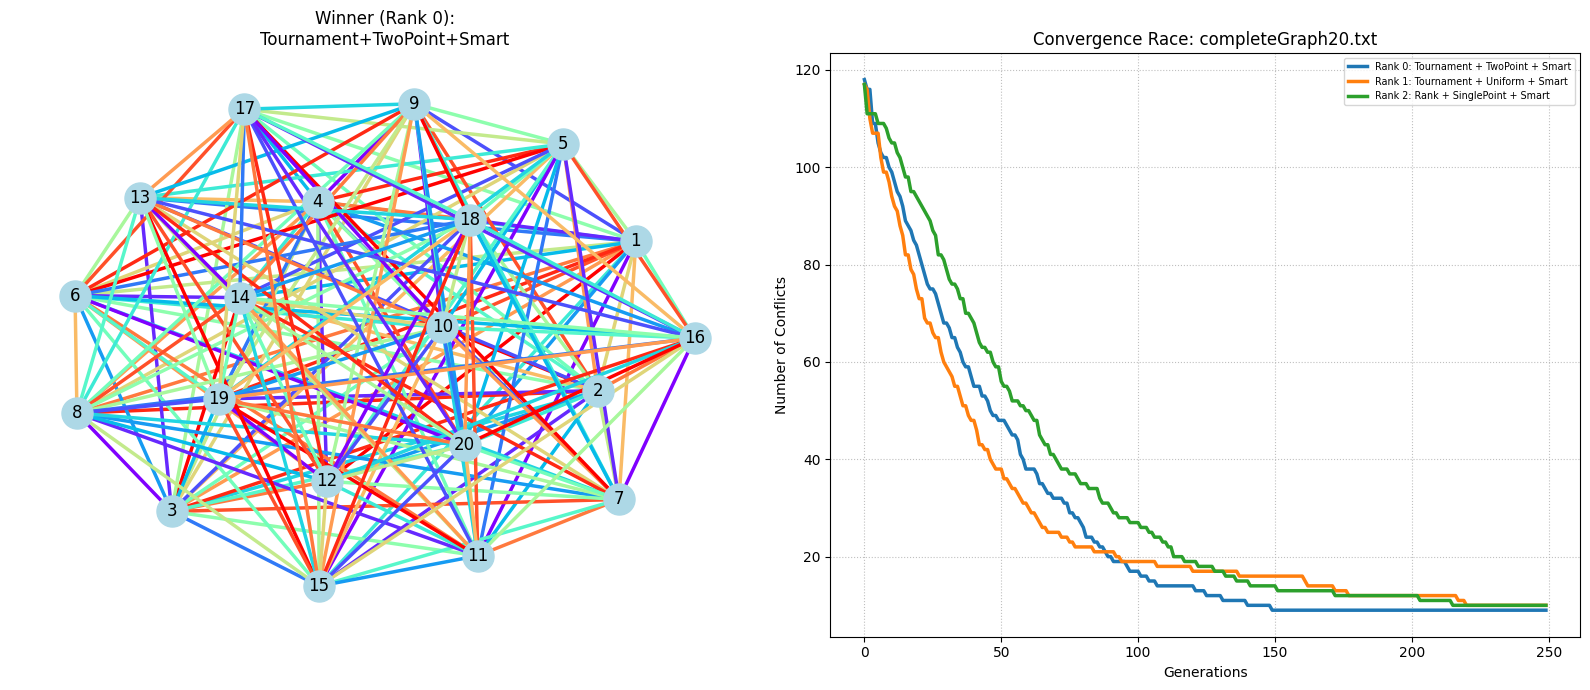

Full table saved to: resultsGA/completeGraph20.txt

>>> ANALYZING: flowerSnark.txt
[TYPE]: SNARK / Petersen Graph
[THEORY]: Class 2 (Expected χ' = Δ + 1 = 4)
Top 3 Combinations for flowerSnark.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │           0 │         4 │ 0.009114 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Tournament  │ SinglePoint │ Smart      │           0 │         4 │ 0.010264 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ TwoPoint    │ Swap       │           0 │         4 │ 0.012095 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════╛


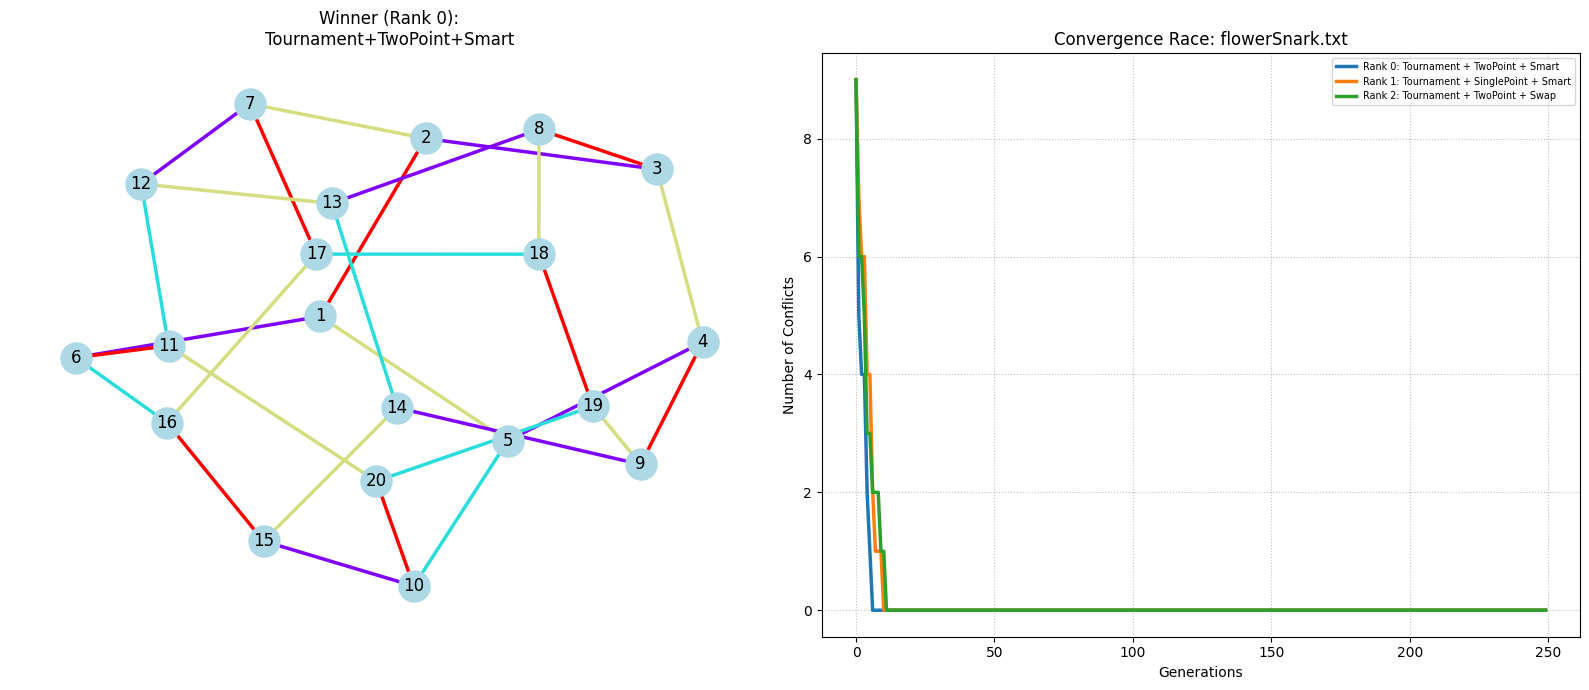

Full table saved to: resultsGA/flowerSnark.txt

>>> ANALYZING: gcol.txt
[TYPE]: Unknown Graph Type
Top 3 Combinations for gcol.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │         791 │        62 │  9.52774 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Rank        │ Uniform     │ Smart      │         847 │        62 │ 10.1371  │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Swap       │         934 │        62 │  8.34856 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════╛


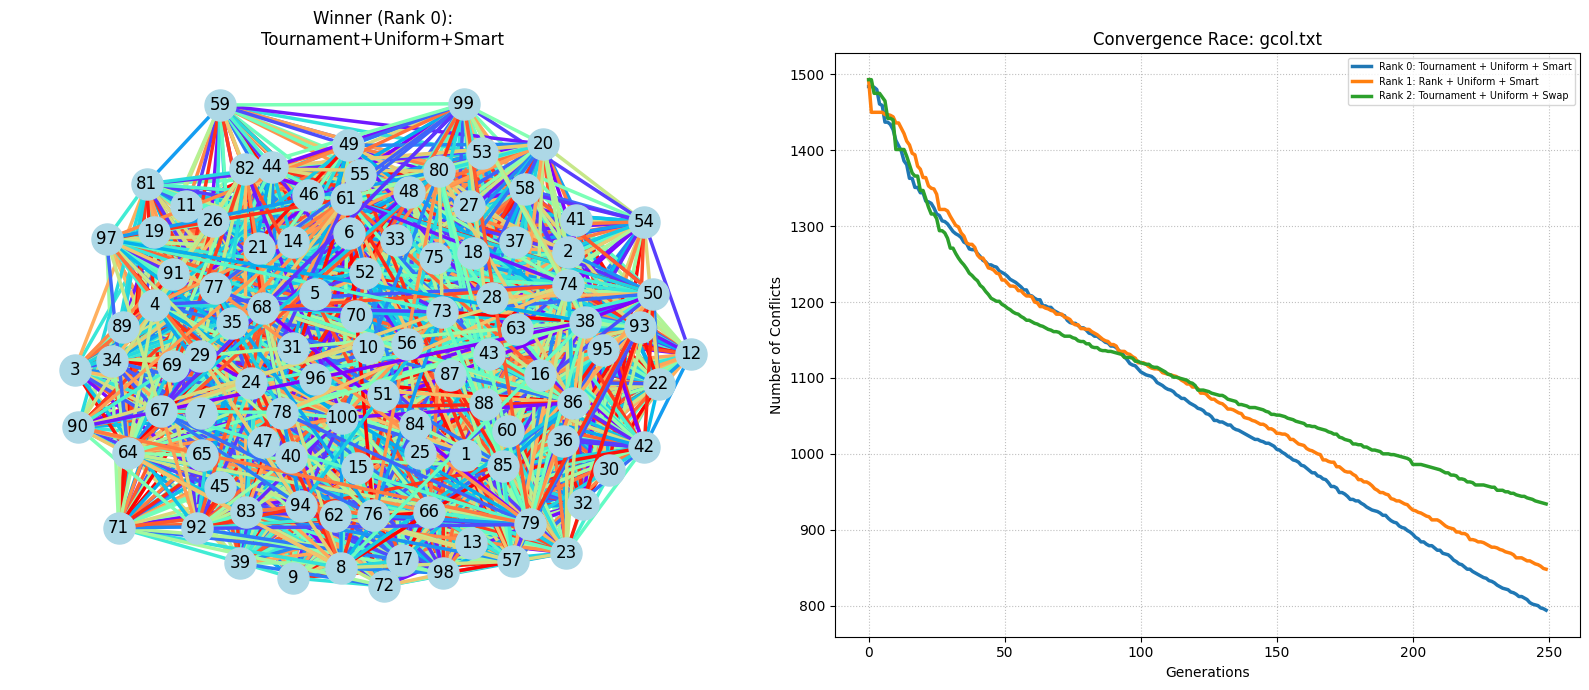

Full table saved to: resultsGA/gcol.txt

>>> ANALYZING: graph100_0.5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph100_0.5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │         701 │        65 │  9.23176 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Rank        │ Uniform     │ Smart      │         742 │        65 │ 10.8754  │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Swap       │         885 │        65 │  8.31658 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════╛


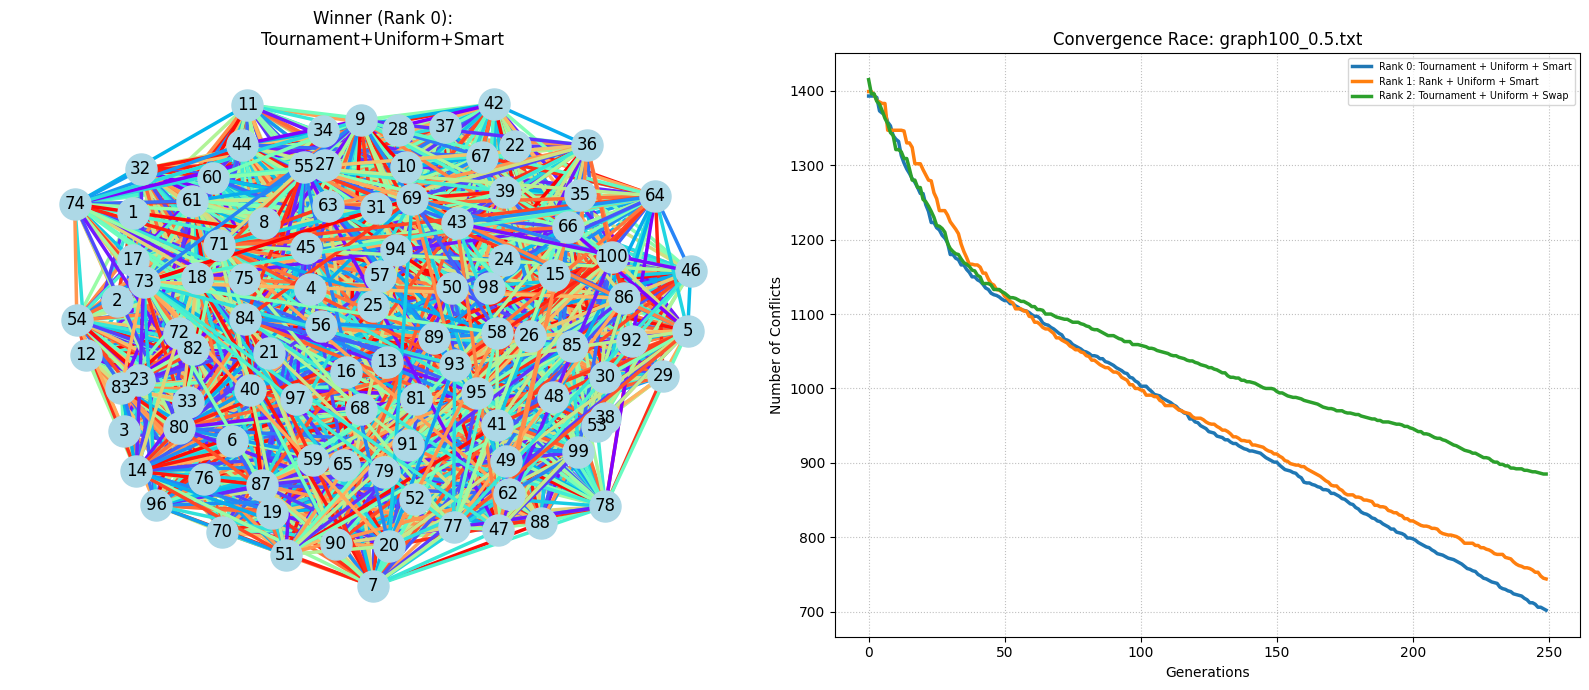

Full table saved to: resultsGA/graph100_0.5.txt

>>> ANALYZING: graph40_0.8.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph40_0.8.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤═════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │    Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │          19 │        36 │ 2.43651 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │          31 │        36 │ 3.0554  │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │          35 │        36 │ 1.75477 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧═════════╛


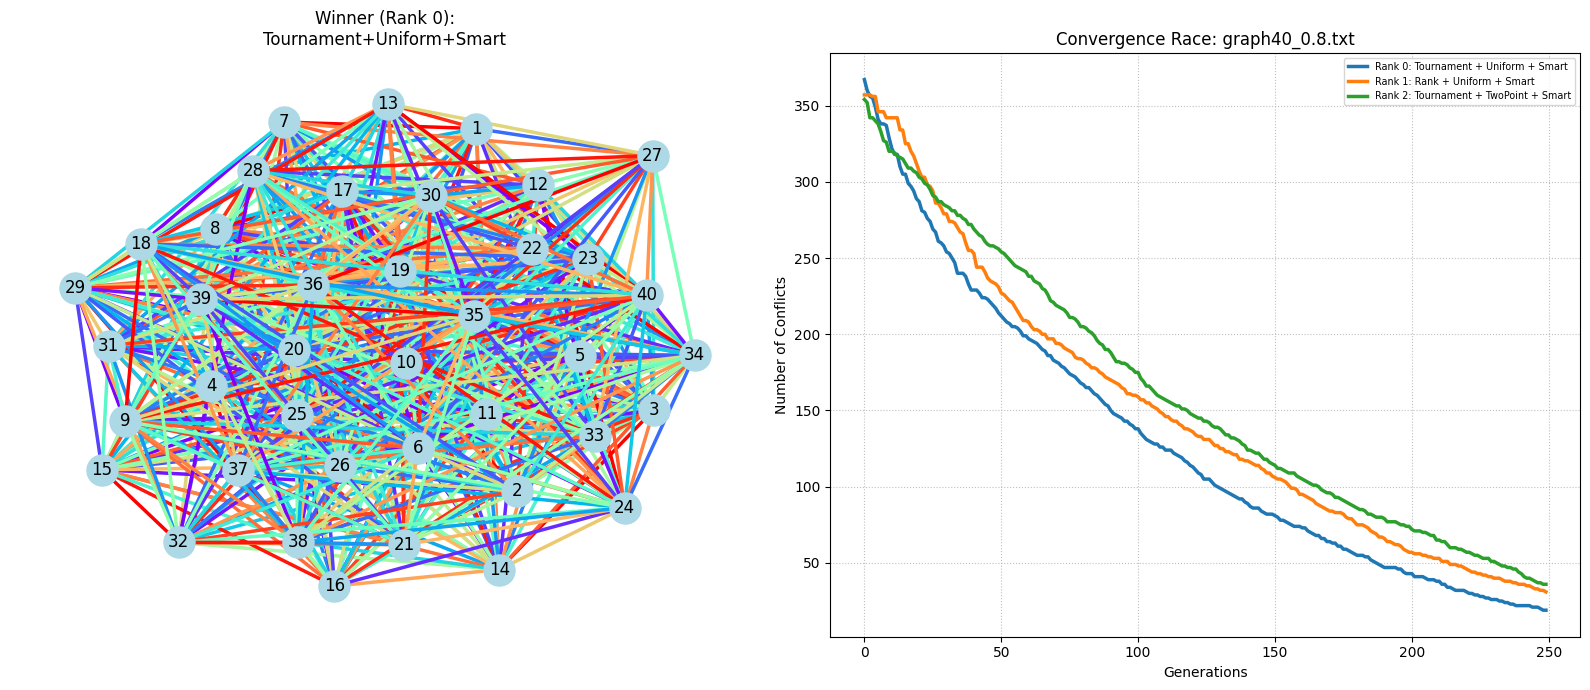

Full table saved to: resultsGA/graph40_0.8.txt

>>> ANALYZING: graph50_0.5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph50_0.5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤═════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │    Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │          18 │        33 │ 2.64547 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │          28 │        33 │ 3.16899 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │          41 │        33 │ 1.67516 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧═════════╛


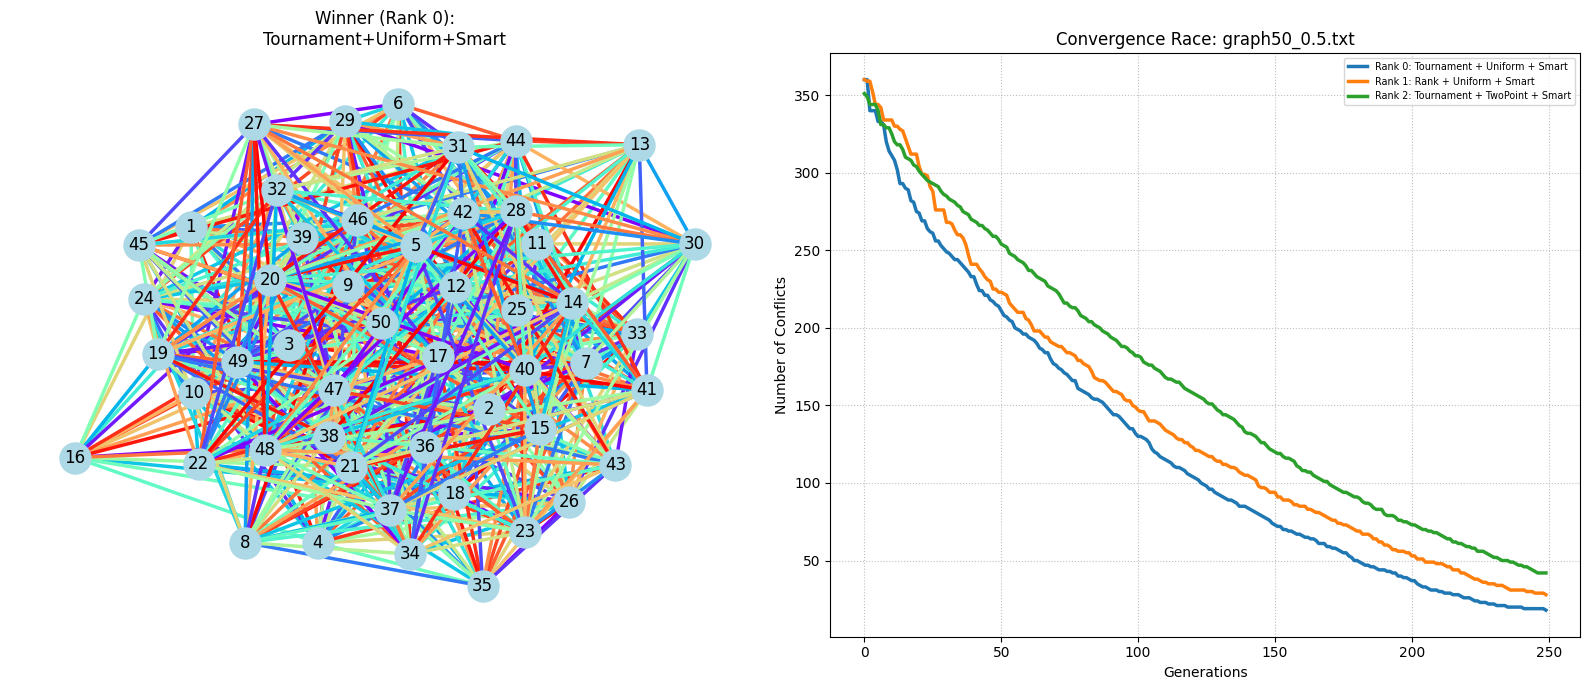

Full table saved to: resultsGA/graph50_0.5.txt

>>> ANALYZING: petersen.txt
[TYPE]: SNARK / Petersen Graph
[THEORY]: Class 2 (Expected χ' = Δ + 1 = 4)
Top 3 Combinations for petersen.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Roulette    │ TwoPoint    │ Smart      │           0 │         4 │ 0.003832 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │           0 │         4 │ 0.003833 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ SinglePoint │ Smart      │           0 │         4 │ 0.004324 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════╛


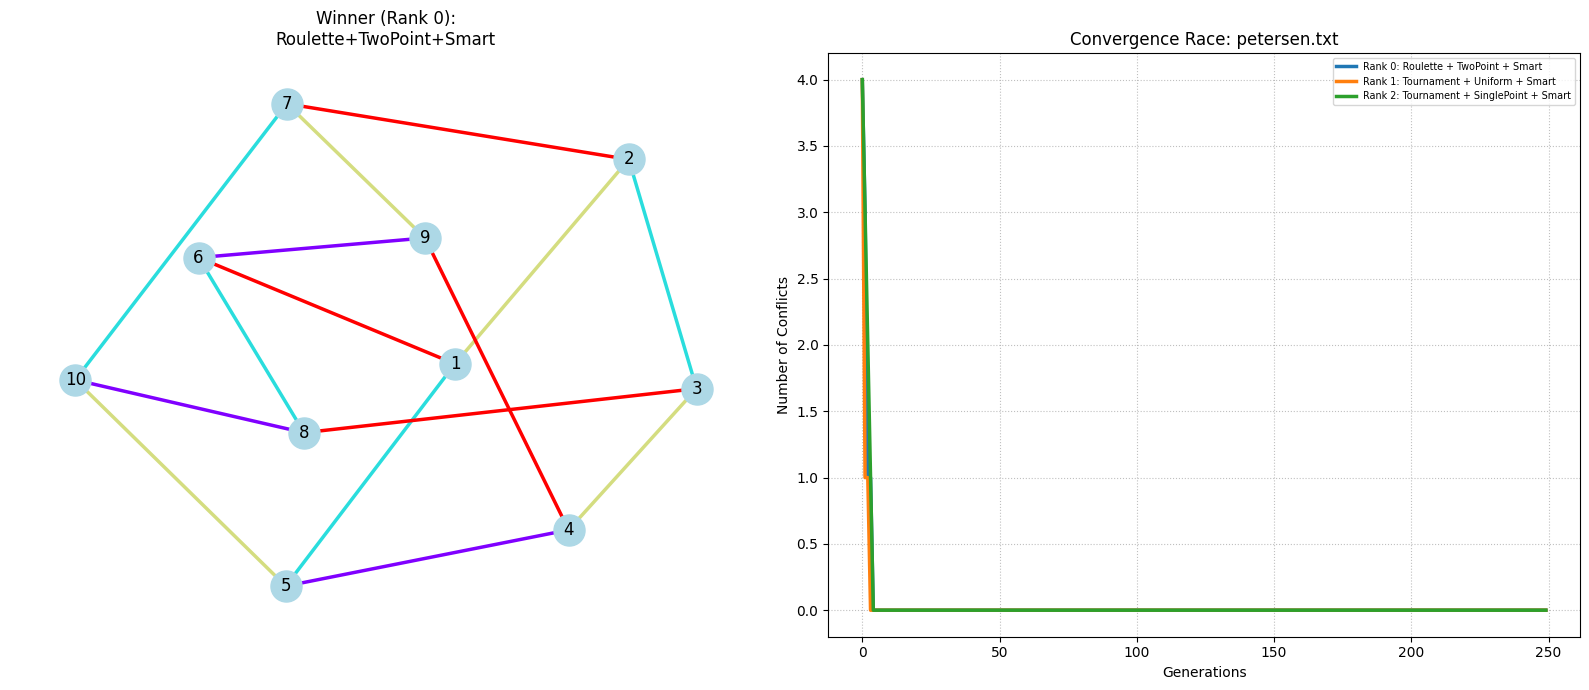

Full table saved to: resultsGA/petersen.txt

>>> ANALYZING: randomGraph5_50.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph5_50.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Rank        │ Uniform     │ Smart      │           1 │         6 │ 0.994567 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Tournament  │ SinglePoint │ Smart      │           2 │         6 │ 0.541989 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Tournament  │ Uniform     │ Smart      │           2 │         6 │ 0.682215 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════╛


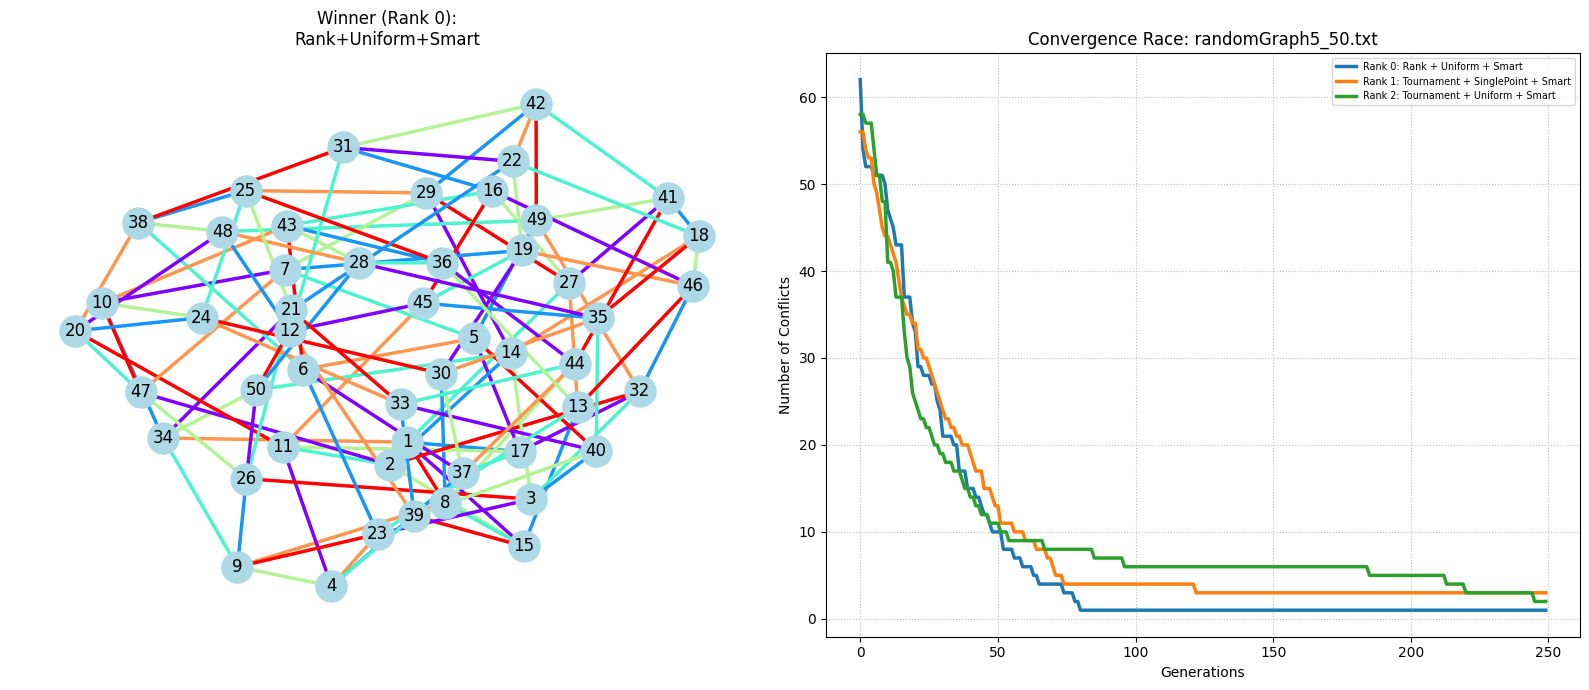

Full table saved to: resultsGA/randomGraph5_50.txt

>>> ANALYZING: randomGraph6_30.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph6_30.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤══════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │     Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪══════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │           0 │         7 │ 0.283958 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      1 │ Roulette    │ Uniform     │ Smart      │           0 │         7 │ 0.495559 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼──────────┤
│      2 │ Rank        │ TwoPoint    │ Smart      │           1 │         7 │ 0.745459 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧══════════╛

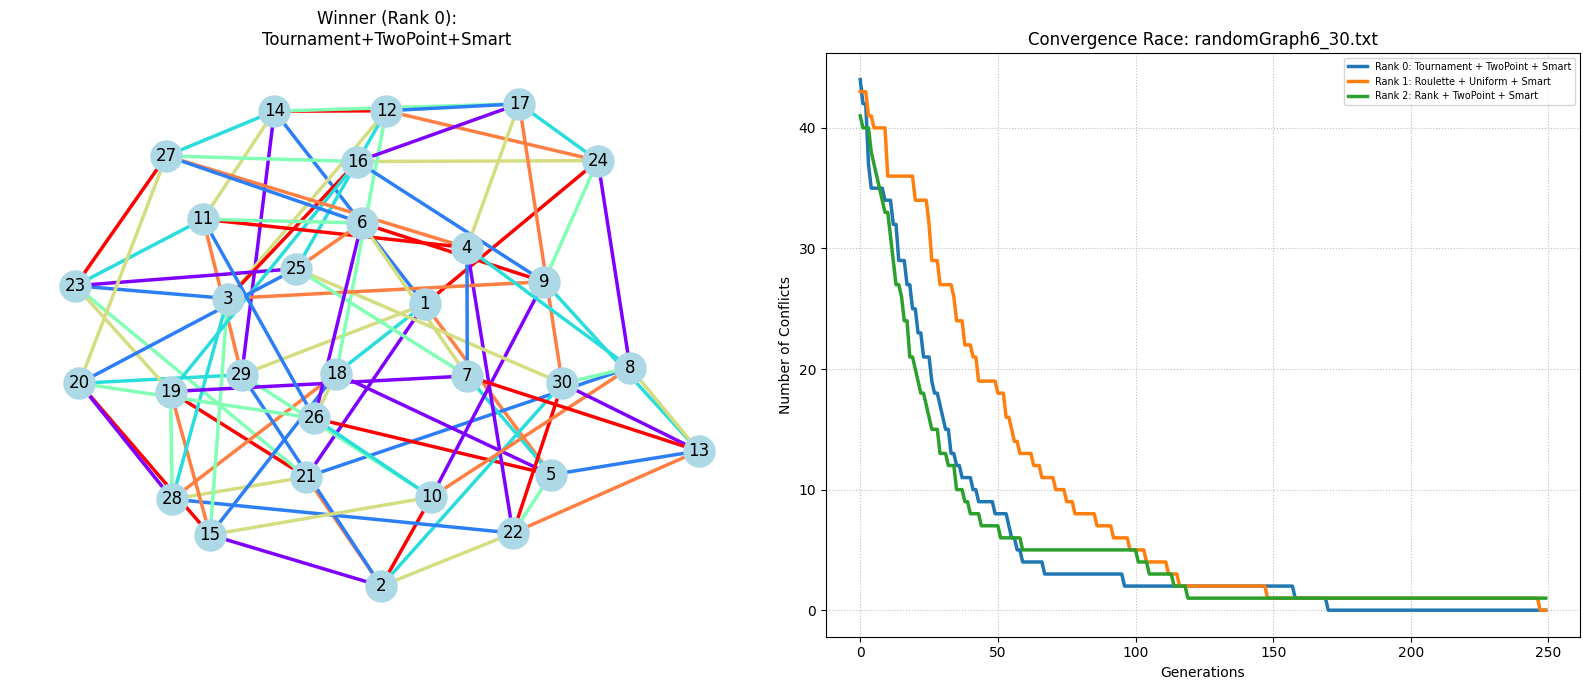

Full table saved to: resultsGA/randomGraph6_30.txt

>>> ANALYZING: randomGraph6_90.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph6_90.txt:
╒════════╤═════════════╤═════════════╤════════════╤═════════════╤═══════════╤═════════╕
│   Rank │ Selection   │ Crossover   │ Mutation   │   Conflicts │   Colours │    Time │
╞════════╪═════════════╪═════════════╪════════════╪═════════════╪═══════════╪═════════╡
│      0 │ Rank        │ Uniform     │ Smart      │          11 │         7 │ 1.63923 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      1 │ Tournament  │ Uniform     │ Smart      │          12 │         7 │ 1.24597 │
├────────┼─────────────┼─────────────┼────────────┼─────────────┼───────────┼─────────┤
│      2 │ Rank        │ SinglePoint │ Smart      │          12 │         7 │ 1.35567 │
╘════════╧═════════════╧═════════════╧════════════╧═════════════╧═══════════╧═════════╛


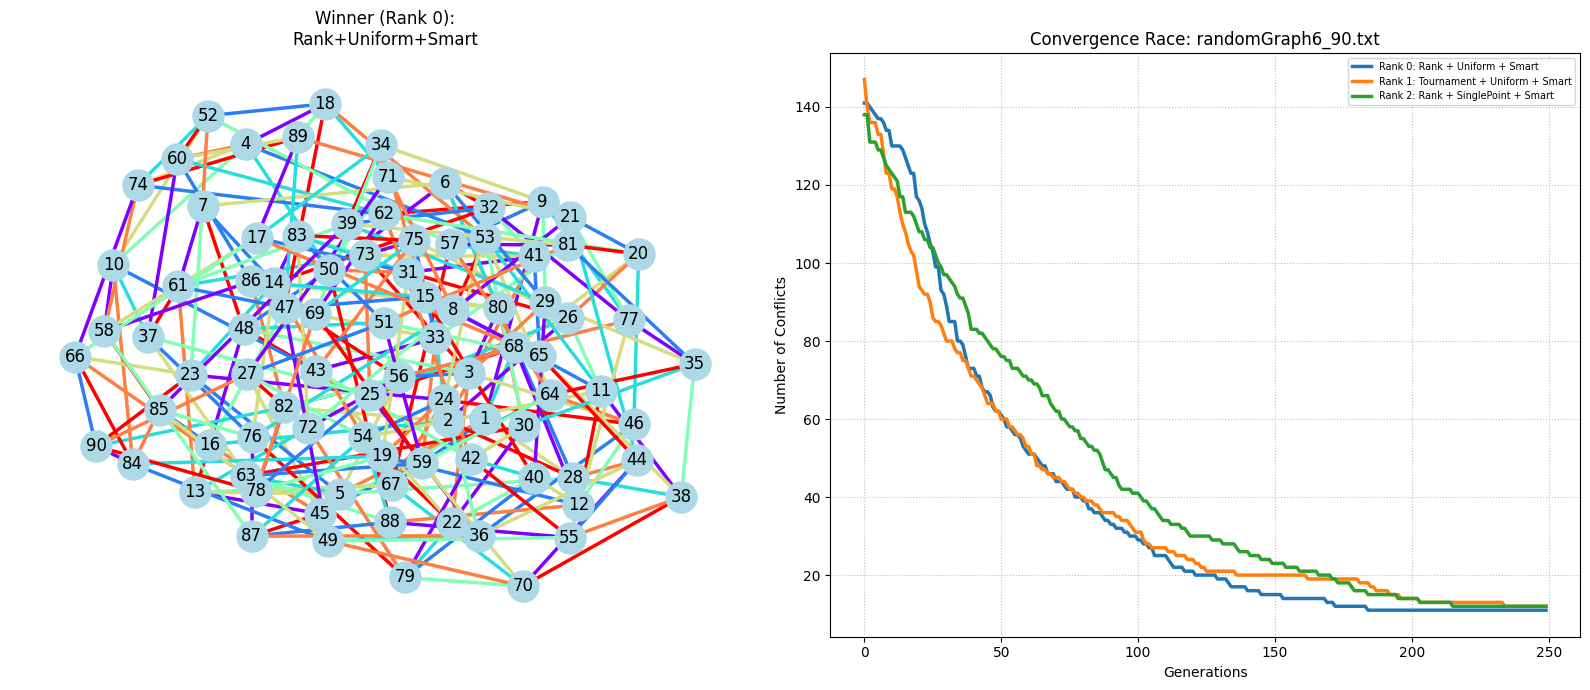

Full table saved to: resultsGA/randomGraph6_90.txt


In [8]:
#Novo ucitavanje fajla

targetFolders = ['experimentalTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)